# Clean ASN Type Classification Pipeline

**Saubere Pipeline ohne Data Leakage:**
- Klarer Train/Val/Test Split (60/20/20)
- Alle Preprocessing nur auf Train gefittet
- Ensemble-Gewichte auf Val optimiert
- Finale Evaluation nur auf Test
- Reproduzierbar mit festen Seeds

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Seeds für Reproduzierbarkeit
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.9.0+cu130
CUDA available: True
GPU: NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition



=== SVM (calibrated) ===
Accuracy: 0.58984375
Macro-F1: 0.43285540823646373
                    precision    recall  f1-score   support

            Access       0.63      0.92      0.75      1532
           Content       0.45      0.33      0.38       323
Education/Research       0.67      0.49      0.56       189
        Enterprise       0.43      0.25      0.31       320
  Network Services       0.64      0.25      0.36       190
           Transit       0.40      0.16      0.23       518

          accuracy                           0.59      3072
         macro avg       0.54      0.40      0.43      3072
      weighted avg       0.55      0.59      0.54      3072

Labels: 6 Klassen -> ['Access', 'Content', 'Education/Research', 'Enterprise', 'Network Services', 'Transit']
Device: cuda
GPU-Name: NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: [0.202 0.959 1.636 0.969 1.636 0.599]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,1.746000,1.596678,0.366862,0.263743,0.289483,0.362318
2,1.516200,1.457060,0.483073,0.374841,0.392251,0.424856
3,1.481000,1.406250,0.486003,0.400102,0.425861,0.457258
4,1.389100,1.370073,0.520508,0.421443,0.406875,0.471499
5,1.359300,1.380287,0.433268,0.391009,0.383940,0.465157
6,1.337200,1.388348,0.534505,0.450723,0.453953,0.474871
7,1.309400,1.370625,0.413411,0.389466,0.392650,0.459906
8,1.287000,1.387206,0.507812,0.436090,0.436423,0.481451


Eval: {'eval_loss': 1.3883479833602905, 'eval_accuracy': 0.5345052083333334, 'eval_f1_macro': 0.45072302179519236, 'eval_precision': 0.4539534672495064, 'eval_recall': 0.47487121102348756, 'eval_runtime': 1.6592, 'eval_samples_per_second': 1851.478, 'eval_steps_per_second': 19.286, 'epoch': 8.0}
Train size: 2457, Test size: 615


100%|██████████| 10/10 [00:00<00:00, 82.11it/s]



=== Ergebnisse auf Test-Set ===
Accuracy: 0.3951219512195122
Macro-F1: 0.3366286817764974

                     precision    recall  f1-score   support

            Access       0.67      0.52      0.59       307
           Content       0.14      0.19      0.16        64
Education/Research       0.70      0.42      0.52        38
        Enterprise       0.20      0.28      0.24        64
  Network Services       0.26      0.45      0.33        38
           Transit       0.17      0.19      0.18       104

          accuracy                           0.40       615
         macro avg       0.36      0.34      0.34       615
      weighted avg       0.46      0.40      0.42       615


=== Ensemble-Gewichtssuche ===
Bestes w (SVM-Anteil): 0.60 | Macro-F1: 0.4815 | Acc: 0.6071

=== Ensemble (SVM^w + XLM-R^(1-w)) auf Eval ===
Accuracy: 0.6070963541666666
Macro-F1: 0.4815323951233615
                    precision    recall  f1-score   support

            Access       0.68      0.87    

XLM-R proba: 100%|██████████| 10/10 [00:00<00:00, 84.50it/s]



=== OOF-Stacking: Ergebnisse auf Test-Set ===
Accuracy: 0.5203252032520326
Macro-F1: 0.45680443817112554

                     precision    recall  f1-score   support

            Access       0.75      0.64      0.69       307
           Content       0.34      0.53      0.41        64
Education/Research       0.68      0.66      0.67        38
        Enterprise       0.29      0.34      0.31        64
  Network Services       0.36      0.45      0.40        38
           Transit       0.27      0.24      0.25       104

          accuracy                           0.52       615
         macro avg       0.45      0.48      0.46       615
      weighted avg       0.55      0.52      0.53       615

Train: 2457 | Test: 615 | Classes: 6


XLM-R proba: 100%|██████████| 8/8 [00:00<00:00, 85.39it/s]



=== Klassen-Gewichte (SVM-Anteil) ===
              Access: w_c = 0.00
             Content: w_c = 0.95
  Education/Research: w_c = 0.70
          Enterprise: w_c = 0.65
    Network Services: w_c = 0.35
             Transit: w_c = 0.40
Macro-F1 (OOF, mit w_c): 0.4772


XLM-R proba: 100%|██████████| 10/10 [00:00<00:00, 83.68it/s]



=== Klassen-gewichtetes Ensemble: Test-Set ===
Accuracy: 0.5365853658536586
Macro-F1: 0.4419999552973843

                     precision    recall  f1-score   support

            Access       0.69      0.75      0.72       307
           Content       0.28      0.27      0.27        64
Education/Research       0.66      0.66      0.66        38
        Enterprise       0.31      0.30      0.30        64
  Network Services       0.52      0.39      0.45        38
           Transit       0.27      0.24      0.25       104

          accuracy                           0.54       615
         macro avg       0.45      0.43      0.44       615
      weighted avg       0.52      0.54      0.53       615

w_c (SVM-Anteil): [0.   0.95 0.7  0.65 0.35 0.4 ]
Accuracy: 0.5365853658536586
Macro-F1: 0.4419999552973843
                    precision    recall  f1-score   support

            Access       0.69      0.75      0.72       307
           Content       0.28      0.27      0.27        64


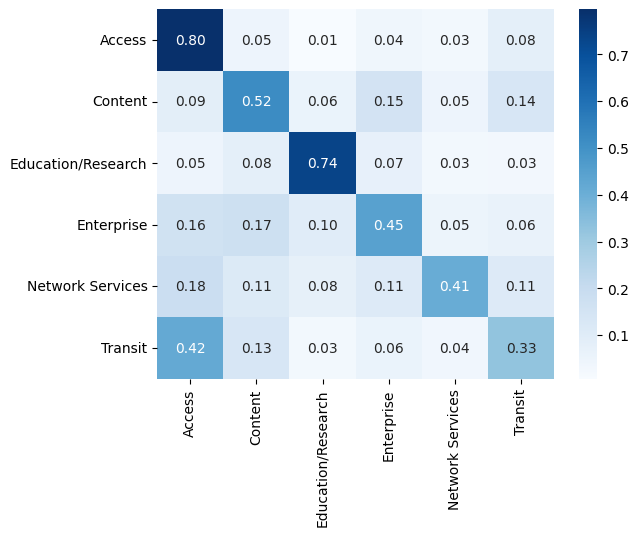

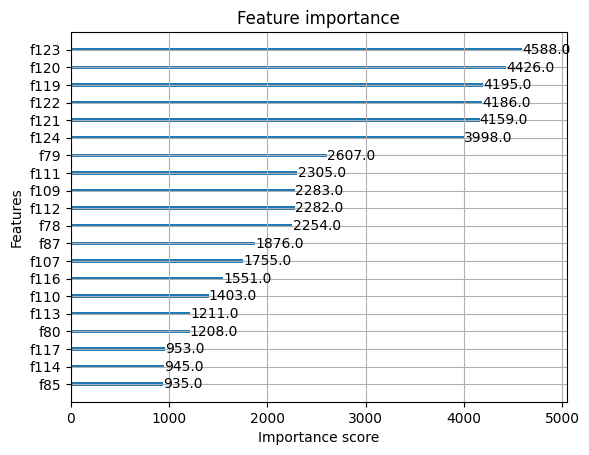

[Xnum_trB_pre] finite=False, shape=(5960, 119)
[P_text_trB] finite=True, shape=(5960, 6)
[Xnum_te_pre] finite=False, shape=(4966, 119)
[P_text_te] finite=True, shape=(4966, 6)


ModuleNotFoundError: No module named 'catboost'

ModuleNotFoundError: No module named 'catboost'

In [5]:
# Lade deine bereits vorbereiteten Daten
import sys
sys.path.insert(0, str(Path.cwd().parent.parent))

# Importiere das alte Notebook um auf die Daten zuzugreifen
%run ../classificator/text_classification.ipynb

# Verwende die vorbereiteten Daten
df_full = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()

print(f"Dataset shape: {df_full.shape}")
print(f"Columns: {list(df_full.columns)[:10]}...")  # Erste 10 Spalten
if 'info_type' in df_full.columns:
    print(f"\nClass distribution:\n{df_full['info_type'].value_counts()}")

In [7]:
from sklearn.preprocessing import LabelEncoder

# Kopiere DataFrame
df = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()

# Bereinigung
df = df[df['org_name'].notna()].copy()
df = df[df['info_type'].notna()].copy()
df['org_name'] = df['org_name'].astype(str).str.strip()

# Filtere kleine Klassen (mind. 10 Samples für sauberen Split)
MIN_SAMPLES = 10
class_counts = df['info_type'].value_counts()
valid_classes = class_counts[class_counts >= MIN_SAMPLES].index
df = df[df['info_type'].isin(valid_classes)].copy()

print(f"After filtering: {len(df)} samples")
print(f"Classes: {sorted(df['info_type'].unique())}")
print(f"\nClass distribution:\n{df['info_type'].value_counts()}")

# Label Encoding
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['info_type'])
label_names = list(le.classes_)
num_classes = len(label_names)

print(f"\nLabel mapping:")
for i, name in enumerate(label_names):
    count = (df['label_id'] == i).sum()
    print(f"  {i}: {name:20s} ({count} samples)")

After filtering: 24830 samples
Classes: ['Access', 'Content', 'Education/Research', 'Enterprise', 'Network Services', 'Transit']

Class distribution:
info_type
Access                12553
Transit                4151
Enterprise             2577
Content                2538
Education/Research     1506
Network Services       1505
Name: count, dtype: int64

Label mapping:
  0: Access               (12553 samples)
  1: Content              (2538 samples)
  2: Education/Research   (1506 samples)
  3: Enterprise           (2577 samples)
  4: Network Services     (1505 samples)
  5: Transit              (4151 samples)


In [8]:
from sklearn.model_selection import train_test_split

# Extrahiere Features und Labels
X_text = df['org_name'].tolist()
y = df['label_id'].to_numpy()

# Schritt 1: Train+Val (80%) vs Test (20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_text, y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)

# Schritt 2: Train (60%) vs Val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 vom Gesamten
    random_state=SEED,
    stratify=y_trainval
)

print(f"✓ Train set: {len(X_train):4d} samples ({len(X_train)/len(X_text)*100:.1f}%)")
print(f"✓ Val set:   {len(X_val):4d} samples ({len(X_val)/len(X_text)*100:.1f}%)")
print(f"✓ Test set:  {len(X_test):4d} samples ({len(X_test)/len(X_text)*100:.1f}%)")
print(f"  Total:     {len(X_train) + len(X_val) + len(X_test):4d} samples")

# Speichere Split-Info
np.save('clean_split_train_idx.npy', np.arange(len(X_train)))
np.save('clean_split_val_idx.npy', np.arange(len(X_val)))
np.save('clean_split_test_idx.npy', np.arange(len(X_test)))
print(f"\n✓ Split indices saved (seed={SEED})")

✓ Train set: 14898 samples (60.0%)
✓ Val set:   4966 samples (20.0%)
✓ Test set:  4966 samples (20.0%)
  Total:     24830 samples

✓ Split indices saved (seed=42)


In [24]:
def build_numeric_features(df_input):
    """
    Extrahiere und transformiere numerische Features.
    Robust gegen fehlende Spalten.
    """
    def numify(s): 
        return pd.to_numeric(s, errors='coerce')
    
    df = df_input.copy()
    X = pd.DataFrame(index=df.index)
    
    # Kategorische Features
    cat_cols_all = ['country', 'source']
    # Prozent-Features
    pct_cols = ['pct_ips_le_100km', 'pct_ips_le_500km', 'pct_ips_le_1000km']
    # Log-transformierte Features (heavy-tailed)
    log_cols = [
        'rank', 'domains',
        'asnDegree_total', 'asnDegree_customer', 'asnDegree_peer', 'asnDegree_provider',
        'cone_numberAsns', 'cone_numberPrefixes', 'cone_numberAddresses',
        'total_weight', 'unique_points', 'country_count',
        'mean_km', 'std_km', 'iqr_km', 'p50_km', 'p90_km', 'p95_km', 'p99_km'
    ]
    # Geo-Features
    geo_cols = ['center_lat', 'center_lon']
    
    present = set(df.columns)
    
    # 1. Prozent → [0,1]
    for c in pct_cols:
        if c in present:
            X[c] = numify(df[c]) / 100.0
    
    # 2. Log1p für heavy-tailed
    for c in log_cols:
        if c in present:
            X[c + '_log1p'] = np.log1p(np.clip(numify(df[c]), 0, None))
    
    # 3. Geo: sin/cos encoding
    if all(c in present for c in geo_cols):
        lat = np.deg2rad(numify(df['center_lat']))
        lon = np.deg2rad(numify(df['center_lon']))
        X['sin_lat'] = np.sin(lat)
        X['cos_lat'] = np.cos(lat)
        X['sin_lon'] = np.sin(lon)
        X['cos_lon'] = np.cos(lon)
    
    # 4. Abgeleitete Features
    eps = 1e-6
    if 'std_km' in present and 'mean_km' in present:
        X['cv_km'] = numify(df['std_km']) / (numify(df['mean_km']) + eps)
    
    if 'iqr_km' in present and 'mean_km' in present:
        X['iqr_ratio'] = numify(df['iqr_km']) / (numify(df['mean_km']) + eps)
    
    if 'asnDegree_customer' in present and 'asnDegree_provider' in present:
        X['customer_provider_ratio'] = numify(df['asnDegree_customer']) / (numify(df['asnDegree_provider']) + eps)
    
    if 'asnDegree_peer' in present and 'asnDegree_provider' in present:
        X['peer_provider_ratio'] = numify(df['asnDegree_peer']) / (numify(df['asnDegree_provider']) + eps)
    
    if 'pct_ips_le_1000km' in present and 'pct_ips_le_100km' in present:
        X['mid_spread'] = (numify(df['pct_ips_le_1000km']) - numify(df['pct_ips_le_100km'])) / 100.0
    
    # 5. Kategorische Features
    cat_cols = [c for c in cat_cols_all if c in present]
    for c in cat_cols:
        X[c] = df[c].fillna('unknown').astype('category')
    
    # Fehlende Features ausgeben
    missing = (set(pct_cols + log_cols + geo_cols) - present)
    if missing:
        print(f"⚠️  Fehlende Features: {len(missing)}")
        print(f"   (z.B.: {list(missing)[:3]}...)")
    
    print(f"✓ Numerische Features: {X.shape[1]} Features extrahiert")
    print(f"  - Continuous: {X.select_dtypes(include=[np.number]).shape[1]}")
    print(f"  - Categorical: {len([c for c in X.columns if X[c].dtype.name == 'category'])}")
    
    return X, cat_cols

# Extrahiere Features für den gesamten gefilterten DataFrame
X_numeric_full, categorical_cols = build_numeric_features(df)

print(f"\n✓ Numeric features shape: {X_numeric_full.shape}")
print(f"✓ Categorical columns: {categorical_cols}")

✓ Numerische Features: 33 Features extrahiert
  - Continuous: 31
  - Categorical: 2

✓ Numeric features shape: (24830, 33)
✓ Categorical columns: ['country', 'source']


In [25]:
# Index-basierter Split (hält Text & Numerik aligned!)
idx_all = np.arange(len(df))

# Schritt 1: Train+Val (80%) vs Test (20%)
idx_trainval, idx_test = train_test_split(
    idx_all,
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)

# Schritt 2: Train (60%) vs Val (20%)
idx_train, idx_val = train_test_split(
    idx_trainval,
    test_size=0.25,
    random_state=SEED,
    stratify=y[idx_trainval]
)

# Extrahiere Text-Features
X_train = [X_text[i] for i in idx_train]
X_val = [X_text[i] for i in idx_val]
X_test = [X_text[i] for i in idx_test]

# Extrahiere Numerische Features (aligned!)
X_train_num = X_numeric_full.iloc[idx_train].reset_index(drop=True)
X_val_num = X_numeric_full.iloc[idx_val].reset_index(drop=True)
X_test_num = X_numeric_full.iloc[idx_test].reset_index(drop=True)

# Labels
y_train = y[idx_train]
y_val = y[idx_val]
y_test = y[idx_test]

print(f"✓ Train set: {len(X_train):4d} samples ({len(X_train)/len(X_text)*100:.1f}%)")
print(f"✓ Val set:   {len(X_val):4d} samples ({len(X_val)/len(X_text)*100:.1f}%)")
print(f"✓ Test set:  {len(X_test):4d} samples ({len(X_test)/len(X_text)*100:.1f}%)")
print(f"  Total:     {len(X_train) + len(X_val) + len(X_test):4d} samples")

print(f"\n✓ Text features: lists of strings")
print(f"✓ Numeric features: {X_train_num.shape[1]} columns")
print(f"  - Train numeric: {X_train_num.shape}")
print(f"  - Val numeric:   {X_val_num.shape}")
print(f"  - Test numeric:  {X_test_num.shape}")

# Speichere Indizes
np.save('clean_split_train_idx.npy', idx_train)
np.save('clean_split_val_idx.npy', idx_val)
np.save('clean_split_test_idx.npy', idx_test)
print(f"\n✓ Split indices saved (seed={SEED})")

✓ Train set: 14898 samples (60.0%)
✓ Val set:   4966 samples (20.0%)
✓ Test set:  4966 samples (20.0%)
  Total:     24830 samples

✓ Text features: lists of strings
✓ Numeric features: 33 columns
  - Train numeric: (14898, 33)
  - Val numeric:   (4966, 33)
  - Test numeric:  (4966, 33)

✓ Split indices saved (seed=42)


## 3.6. Split mit numerischen Features

**Wichtig:** Split muss index-basiert sein, damit Text & Numerik aligned bleiben!

## 3.5. Numerische Features extrahieren

**Features aus:**
- ASRank (rank, degrees, cone)
- Domains (Anzahl)
- Geolocation (Statistiken, Verteilung)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

print("Training TF-IDF + LinearSVC...")

# Pipeline: TF-IDF + SVM + Calibration
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='char_wb',
        ngram_range=(2, 7),
        lowercase=True,
        sublinear_tf=True,
        strip_accents='unicode',
        min_df=2,
        max_features=10000
    )),
    ('svm', CalibratedClassifierCV(
        LinearSVC(
            C=0.35,
            class_weight='balanced',
            random_state=SEED,
            max_iter=2000
        ),
        method='sigmoid',
        cv=5
    ))
])

# Fit nur auf TRAIN!
svm_pipeline.fit(X_train, y_train)

# Evaluate auf Val
y_val_pred_svm = svm_pipeline.predict(X_val)
print("\n=== SVM Performance on VAL ===")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_svm):.4f}")
print(f"Macro-F1: {f1_score(y_val, y_val_pred_svm, average='macro'):.4f}")

# Probabilities für Ensemble
P_svm_val = svm_pipeline.predict_proba(X_val)
print(f"\n✓ SVM trained, Val probabilities shape: {P_svm_val.shape}")

Training TF-IDF + LinearSVC...

=== SVM Performance on VAL ===
Accuracy: 0.5838
Macro-F1: 0.4038

✓ SVM trained, Val probabilities shape: (4966, 6)

=== SVM Performance on VAL ===
Accuracy: 0.5838
Macro-F1: 0.4038

✓ SVM trained, Val probabilities shape: (4966, 6)


In [27]:
# Verwende das bereits trainierte XLM-R Modell aus dem anderen Notebook
# (model und tokenizer sind bereits geladen)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Extrahiere Probabilities
@torch.no_grad()
def get_xlmr_probs(texts, batch_size=64, max_length=256):
    model.eval()
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tok(
            batch,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        outputs = model(**encodings)
        probs = torch.softmax(outputs.logits, dim=-1)
        all_probs.append(probs.cpu().numpy())
    
    return np.vstack(all_probs)

print("Extracting XLM-R probabilities on VAL...")
P_xlmr_val = get_xlmr_probs(X_val, max_length=64)

y_val_pred_xlmr = P_xlmr_val.argmax(axis=1)
print("\n=== XLM-R Performance on VAL ===")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_xlmr):.4f}")
print(f"Macro-F1: {f1_score(y_val, y_val_pred_xlmr, average='macro'):.4f}")
print(f"\n✓ XLM-R probabilities shape: {P_xlmr_val.shape}")

Using device: cuda
Extracting XLM-R probabilities on VAL...



=== XLM-R Performance on VAL ===
Accuracy: 0.5308
Macro-F1: 0.4169

✓ XLM-R probabilities shape: (4966, 6)


In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

print("Training Numeric Model (HistGradientBoosting)...")

# OneHotEncoder für kategorische Features
ohe_kwargs = {'handle_unknown': 'ignore', 'min_frequency': 5}
try:
    enc = OneHotEncoder(sparse_output=False, **ohe_kwargs)  # sklearn >= 1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, **ohe_kwargs)  # sklearn < 1.2

# ColumnTransformer: OHE für kategorische, passthrough für kontinuierliche
numeric_cols = [c for c in X_train_num.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', enc, categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ],
    remainder='drop',
    sparse_threshold=0.0  # Dense output
)

# HistGradientBoosting (nativ mit kategorischen Features, aber wir verwenden OHE für Konsistenz)
numeric_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_iter=300,
        max_depth=None,
        min_samples_leaf=20,
        random_state=SEED,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ))
])

# Fit nur auf TRAIN!
numeric_model.fit(X_train_num, y_train)

# Kalibrierung auf Val für bessere Probabilities
print("Calibrating numeric model...")
numeric_cal = CalibratedClassifierCV(
    numeric_model.named_steps['clf'],
    method='isotonic',
    cv='prefit'
)

# Transformiere Val-Daten und kalibriere
X_val_num_transformed = numeric_model.named_steps['preprocess'].transform(X_val_num)
numeric_cal.fit(X_val_num_transformed, y_val)

# Evaluate auf Val
X_val_num_prep = numeric_model.named_steps['preprocess'].transform(X_val_num)
P_numeric_val = numeric_cal.predict_proba(X_val_num_prep)
y_val_pred_numeric = P_numeric_val.argmax(axis=1)

print("\n=== Numeric Model Performance on VAL ===")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_numeric):.4f}")
print(f"Macro-F1: {f1_score(y_val, y_val_pred_numeric, average='macro'):.4f}")
print(f"\n✓ Numeric model trained, Val probabilities shape: {P_numeric_val.shape}")

Training Numeric Model (HistGradientBoosting)...
Calibrating numeric model...

=== Numeric Model Performance on VAL ===
Accuracy: 0.5918
Macro-F1: 0.4025

✓ Numeric model trained, Val probabilities shape: (4966, 6)
Calibrating numeric model...

=== Numeric Model Performance on VAL ===
Accuracy: 0.5918
Macro-F1: 0.4025

✓ Numeric model trained, Val probabilities shape: (4966, 6)


## 5.5. Model 3: Numerische Features + HistGradientBoosting

**Nur numerische Features**, kalibriert für gute Probabilities

In [29]:
def optimize_three_model_weights(P_svm, P_xlmr, P_numeric, y_true, grid_steps=11):
    """
    Optimiere pro Klasse c Gewichte [w_svm, w_xlmr, w_numeric] auf dem Simplex:
    w_svm + w_xlmr + w_numeric = 1, alle >= 0
    
    Maximiert Macro-F1.
    """
    C = P_svm.shape[1]
    # Start: gleichgewichtet
    weights = np.full((C, 3), 1/3)  # [C, 3] - pro Klasse 3 Gewichte
    
    grid = np.linspace(0.0, 1.0, grid_steps)
    
    def compute_f1(W):
        """W ist [C, 3] Array"""
        P_mix = np.zeros_like(P_svm)
        for c in range(C):
            P_mix[:, c] = (
                W[c, 0] * P_svm[:, c] + 
                W[c, 1] * P_xlmr[:, c] + 
                W[c, 2] * P_numeric[:, c]
            )
        preds = P_mix.argmax(axis=1)
        return f1_score(y_true, preds, average='macro')
    
    best_f1 = compute_f1(weights)
    
    # Coordinate descent auf dem Simplex
    for iteration in range(5):
        improved = False
        
        for c in range(C):
            best_w_c = weights[c].copy()
            best_f1_c = best_f1
            
            # Durchsuche 2D-Simplex: w1 + w2 + w3 = 1
            for w1 in grid:
                for w2 in grid:
                    w3 = 1.0 - w1 - w2
                    if w3 < -1e-6 or w3 > 1.0 + 1e-6:
                        continue  # außerhalb Simplex
                    w3 = np.clip(w3, 0, 1)
                    
                    W_try = weights.copy()
                    W_try[c] = [w1, w2, w3]
                    
                    f1 = compute_f1(W_try)
                    if f1 > best_f1_c:
                        best_f1_c = f1
                        best_w_c = [w1, w2, w3]
            
            if not np.allclose(best_w_c, weights[c]):
                weights[c] = best_w_c
                best_f1 = best_f1_c
                improved = True
        
        if not improved:
            break
        print(f"  Iteration {iteration+1}: F1={best_f1:.4f}")
    
    return weights, best_f1

print("Optimizing 3-model ensemble weights on VAL set...")
print("(This may take a few minutes...)\n")

ensemble_weights_3, val_f1_3 = optimize_three_model_weights(
    P_svm_val, 
    P_xlmr_val,
    P_numeric_val,
    y_val,
    grid_steps=11  # 11x11 grid pro Klasse
)

print("\n=== Per-Class 3-Model Ensemble Weights ===")
print(f"{'Class':>20s}  {'SVM':>6s}  {'XLM-R':>6s}  {'Numeric':>8s}")
print("-" * 50)
for i, name in enumerate(label_names):
    w = ensemble_weights_3[i]
    print(f"{name:>20s}  {w[0]:>6.3f}  {w[1]:>6.3f}  {w[2]:>8.3f}")

print(f"\n✓ Val Macro-F1 with 3-model ensemble: {val_f1_3:.4f}")

Optimizing 3-model ensemble weights on VAL set...
(This may take a few minutes...)

  Iteration 1: F1=0.5077
  Iteration 1: F1=0.5077
  Iteration 2: F1=0.5238
  Iteration 2: F1=0.5238
  Iteration 3: F1=0.5248
  Iteration 3: F1=0.5248

=== Per-Class 3-Model Ensemble Weights ===
               Class     SVM   XLM-R   Numeric
--------------------------------------------------
              Access   0.000   0.900     0.100
             Content   0.400   0.100     0.500
  Education/Research   0.600   0.000     0.400
          Enterprise   0.200   0.400     0.400
    Network Services   0.300   0.200     0.500
             Transit   0.000   0.300     0.700

✓ Val Macro-F1 with 3-model ensemble: 0.5248

=== Per-Class 3-Model Ensemble Weights ===
               Class     SVM   XLM-R   Numeric
--------------------------------------------------
              Access   0.000   0.900     0.100
             Content   0.400   0.100     0.500
  Education/Research   0.600   0.000     0.400
          Ent

In [30]:
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("🎯 FINAL EVALUATION ON HELD-OUT TEST SET")
print("="*70)

# Predictions auf Test (JETZT ERST!)
print("\nGenerating predictions on test set...")
P_svm_test = svm_pipeline.predict_proba(X_test)
P_xlmr_test = get_xlmr_probs(X_test, max_length=64)

# Numeric predictions
X_test_num_prep = numeric_model.named_steps['preprocess'].transform(X_test_num)
P_numeric_test = numeric_cal.predict_proba(X_test_num_prep)

# Einzelmodelle
y_pred_svm = P_svm_test.argmax(axis=1)
y_pred_xlmr = P_xlmr_test.argmax(axis=1)
y_pred_numeric = P_numeric_test.argmax(axis=1)

print("\n=== Individual Model Performance on TEST ===")
print(f"\nSVM (Text only):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"  Macro-F1: {f1_score(y_test, y_pred_svm, average='macro'):.4f}")

print(f"\nXLM-R (Text only):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xlmr):.4f}")
print(f"  Macro-F1: {f1_score(y_test, y_pred_xlmr, average='macro'):.4f}")

print(f"\nNumeric Model (Metadata only):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_numeric):.4f}")
print(f"  Macro-F1: {f1_score(y_test, y_pred_numeric, average='macro'):.4f}")

# 3-Model Ensemble mit optimierten Gewichten
P_ensemble_test = np.zeros_like(P_svm_test)
for c in range(num_classes):
    w = ensemble_weights_3[c]
    P_ensemble_test[:, c] = (
        w[0] * P_svm_test[:, c] + 
        w[1] * P_xlmr_test[:, c] + 
        w[2] * P_numeric_test[:, c]
    )

y_pred_ensemble = P_ensemble_test.argmax(axis=1)

print("\n" + "="*70)
print("🏆 3-MODEL ENSEMBLE (Text + Numeric) on TEST")
print("="*70)
test_acc = accuracy_score(y_test, y_pred_ensemble)
test_f1 = f1_score(y_test, y_pred_ensemble, average='macro')
print(f"Accuracy:  {test_acc:.4f}")
print(f"Macro-F1:  {test_f1:.4f}")

# Verbesserung gegenüber bestem Einzelmodell
best_single_f1 = max(
    f1_score(y_test, y_pred_svm, average='macro'),
    f1_score(y_test, y_pred_xlmr, average='macro'),
    f1_score(y_test, y_pred_numeric, average='macro')
)
improvement = ((test_f1 - best_single_f1) / best_single_f1) * 100
print(f"Improvement over best single model: +{improvement:.2f}%")

print("\n" + classification_report(
    y_test, 
    y_pred_ensemble, 
    target_names=label_names,
    digits=4
))


🎯 FINAL EVALUATION ON HELD-OUT TEST SET

Generating predictions on test set...

=== Individual Model Performance on TEST ===

SVM (Text only):
  Accuracy: 0.5830
  Macro-F1: 0.3974

XLM-R (Text only):
  Accuracy: 0.5401
  Macro-F1: 0.4233

Numeric Model (Metadata only):
  Accuracy: 0.5822
  Macro-F1: 0.3843

🏆 3-MODEL ENSEMBLE (Text + Numeric) on TEST
Accuracy:  0.6152
Macro-F1:  0.4946
Improvement over best single model: +16.85%

                    precision    recall  f1-score   support

            Access     0.7170    0.8455    0.7760      2511
           Content     0.3980    0.4803    0.4353       508
Education/Research     0.6373    0.6478    0.6425       301
        Enterprise     0.4317    0.3495    0.3863       515
  Network Services     0.6538    0.2824    0.3944       301
           Transit     0.4230    0.2747    0.3331       830

          accuracy                         0.6152      4966
         macro avg     0.5435    0.4800    0.4946      4966
      weighted avg    

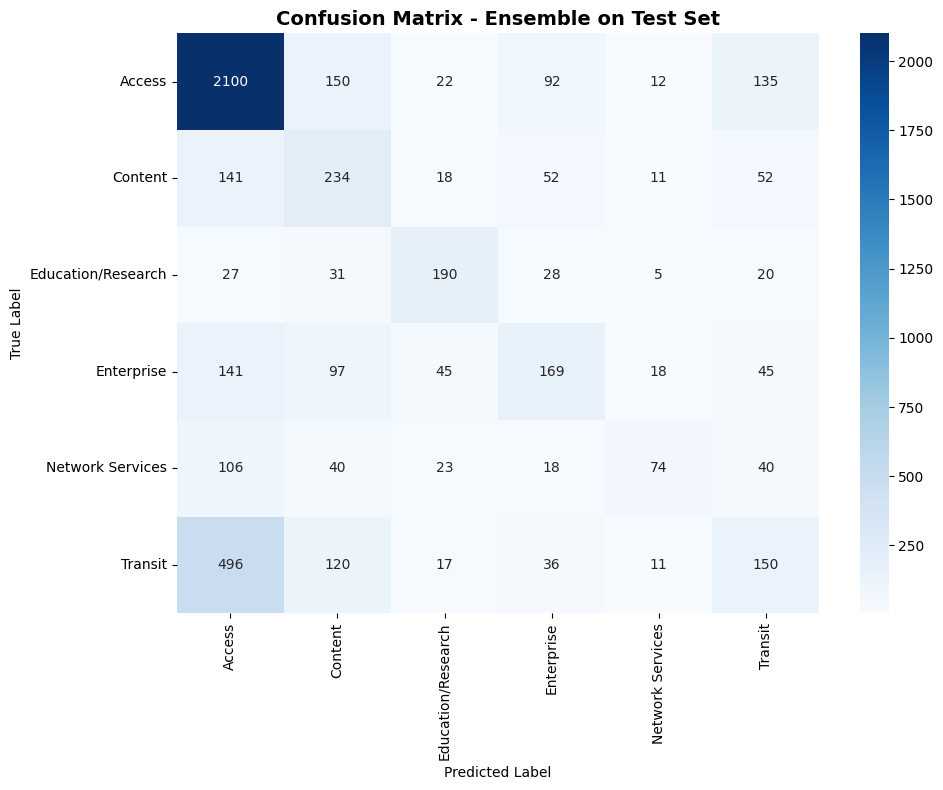


=== Per-Class Performance ===
              Access: 2100/2511 = 83.6%
             Content: 234/508 = 46.1%
  Education/Research: 190/301 = 63.1%
          Enterprise: 169/515 = 32.8%
    Network Services:  74/301 = 24.6%
             Transit: 150/830 = 18.1%


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('Confusion Matrix - Ensemble on Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class performance
print("\n=== Per-Class Performance ===")
for i, name in enumerate(label_names):
    mask = (y_test == i)
    if mask.sum() > 0:
        correct = (y_pred_ensemble[mask] == i).sum()
        total = mask.sum()
        print(f"{name:>20s}: {correct:3d}/{total:3d} = {correct/total:.1%}")

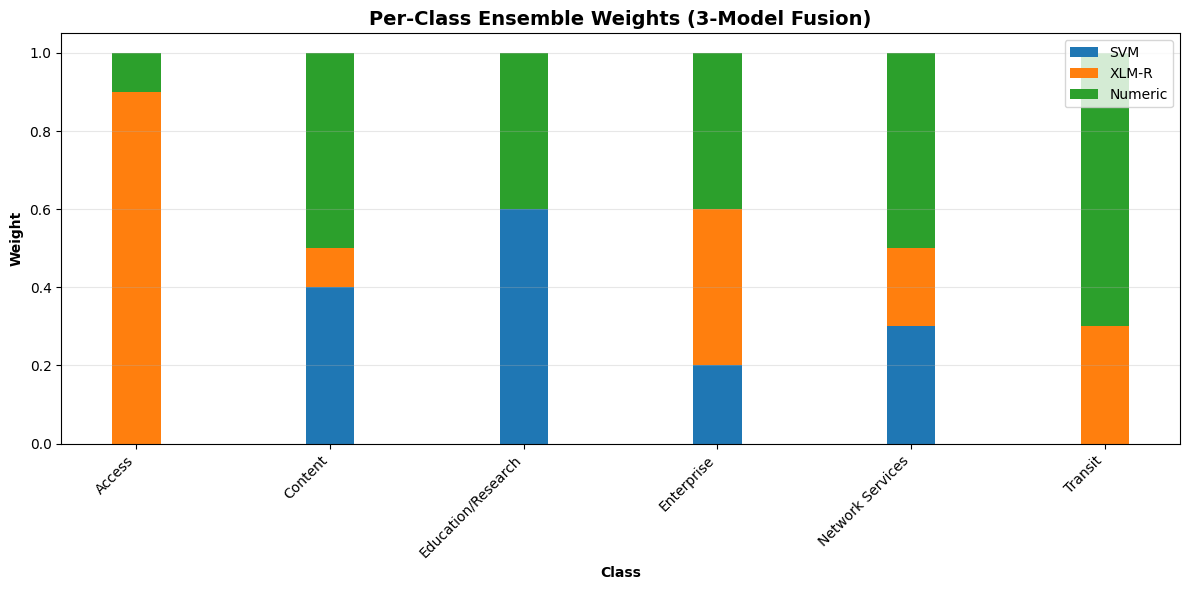


=== Weight Analysis ===
Average weights across classes:
  SVM:     0.250 ± 0.214
  XLM-R:   0.317 ± 0.291
  Numeric: 0.433 ± 0.180

Classes relying most on NUMERIC features:
               Transit: 70.0%
               Content: 50.0%
      Network Services: 50.0%

Classes relying most on TEXT features (SVM+XLM-R):
                Access: 90.0%
            Enterprise: 60.0%
    Education/Research: 60.0%


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisiere Ensemble-Gewichte pro Klasse
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(label_names))
width = 0.25

# Stacked Bar Chart
p1 = ax.bar(x, ensemble_weights_3[:, 0], width, label='SVM', color='#1f77b4')
p2 = ax.bar(x, ensemble_weights_3[:, 1], width, bottom=ensemble_weights_3[:, 0], 
            label='XLM-R', color='#ff7f0e')
p3 = ax.bar(x, ensemble_weights_3[:, 2], width, 
            bottom=ensemble_weights_3[:, 0] + ensemble_weights_3[:, 1],
            label='Numeric', color='#2ca02c')

ax.set_ylabel('Weight', fontweight='bold')
ax.set_xlabel('Class', fontweight='bold')
ax.set_title('Per-Class Ensemble Weights (3-Model Fusion)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_names, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Weight Analysis ===")
print(f"Average weights across classes:")
print(f"  SVM:     {ensemble_weights_3[:, 0].mean():.3f} ± {ensemble_weights_3[:, 0].std():.3f}")
print(f"  XLM-R:   {ensemble_weights_3[:, 1].mean():.3f} ± {ensemble_weights_3[:, 1].std():.3f}")
print(f"  Numeric: {ensemble_weights_3[:, 2].mean():.3f} ± {ensemble_weights_3[:, 2].std():.3f}")

# Zeige Klassen, die stark auf numerische Features setzen
print(f"\nClasses relying most on NUMERIC features:")
numeric_dominant = np.argsort(ensemble_weights_3[:, 2])[::-1][:3]
for idx in numeric_dominant:
    print(f"  {label_names[idx]:>20s}: {ensemble_weights_3[idx, 2]:.1%}")

print(f"\nClasses relying most on TEXT features (SVM+XLM-R):")
text_weight = ensemble_weights_3[:, 0] + ensemble_weights_3[:, 1]
text_dominant = np.argsort(text_weight)[::-1][:3]
for idx in text_dominant:
    print(f"  {label_names[idx]:>20s}: {text_weight[idx]:.1%}")

## 8.5. Visualisierung der Ensemble-Gewichte

In [32]:
def predict_asn_type(org_names, numeric_features=None, return_probs=False):
    """
    Predict ASN type for new organization names with optional numeric features.
    
    Args:
        org_names: str or list of str
        numeric_features: DataFrame with same structure as X_train_num (optional)
                         If None, only text models will be used
        return_probs: if True, return probabilities
    
    Returns:
        predictions (and optionally probabilities)
    """
    if isinstance(org_names, str):
        org_names = [org_names]
        single_input = True
    else:
        single_input = False
    
    # Text model predictions
    P_svm = svm_pipeline.predict_proba(org_names)
    P_xlmr = get_xlmr_probs(org_names, max_length=64)
    
    # Wenn numerische Features vorhanden sind, verwende 3-Model-Ensemble
    if numeric_features is not None:
        X_num_prep = numeric_model.named_steps['preprocess'].transform(numeric_features)
        P_numeric = numeric_cal.predict_proba(X_num_prep)
        
        # 3-Model-Ensemble
        P_ensemble = np.zeros_like(P_svm)
        for c in range(num_classes):
            w = ensemble_weights_3[c]
            P_ensemble[:, c] = (
                w[0] * P_svm[:, c] + 
                w[1] * P_xlmr[:, c] + 
                w[2] * P_numeric[:, c]
            )
    else:
        # Fallback: Nur Text-Ensemble (SVM + XLM-R mit 2-Model-Gewichten)
        # Verwende einfach gleichgewichtete Kombination
        P_ensemble = 0.5 * P_svm + 0.5 * P_xlmr
        print("⚠️  Warning: Nur Text-Features verwendet (keine numerischen Features)")
    
    predictions = P_ensemble.argmax(axis=1)
    pred_labels = [label_names[p] for p in predictions]
    
    if single_input:
        pred_labels = pred_labels[0]
        P_ensemble = P_ensemble[0]
    
    if return_probs:
        return pred_labels, P_ensemble
    return pred_labels

# Test examples (nur Text - für vollständige Predictions benötigen wir die numerischen Features)
test_examples = [
    "Google LLC",
    "Amazon Web Services",
    "Deutsche Telekom AG",
    "Cogent Communications",
    "University of Cambridge",
    "Level 3 Communications",
    "Cloudflare Inc",
]

print("=== Example Predictions (Text-only, fallback mode) ===\n")
predictions, probs = predict_asn_type(test_examples, return_probs=True)

for name, pred, prob in zip(test_examples, predictions, probs):
    print(f"{name}")
    print(f"  → Predicted: {pred}")
    print(f"  → Confidence: {prob.max():.1%}")
    print(f"  → Top-3: ", end="")
    top3 = np.argsort(prob)[-3:][::-1]
    for idx in top3:
        print(f"{label_names[idx]}({prob[idx]:.1%}) ", end="")
    print("\n")

print("\n" + "="*70)
print("💡 Tipp: Für beste Predictions numerische Features übergeben:")
print("   predictions = predict_asn_type(texts, numeric_features=X_num_df)")
print("="*70)

=== Example Predictions (Text-only, fallback mode) ===

⚠️  Warning: Nur Text-Features verwendet (keine numerischen Features)
Google LLC
  → Predicted: Content
  → Confidence: 51.5%
  → Top-3: Content(51.5%) Access(14.2%) Enterprise(13.0%) 

Amazon Web Services
  → Predicted: Content
  → Confidence: 32.5%
  → Top-3: Content(32.5%) Access(20.9%) Transit(18.5%) 

Deutsche Telekom AG
  → Predicted: Transit
  → Confidence: 36.5%
  → Top-3: Transit(36.5%) Access(30.6%) Enterprise(11.1%) 

Cogent Communications
  → Predicted: Access
  → Confidence: 50.8%
  → Top-3: Access(50.8%) Transit(32.8%) Network Services(6.0%) 

University of Cambridge
  → Predicted: Education/Research
  → Confidence: 82.2%
  → Top-3: Education/Research(82.2%) Access(4.4%) Network Services(4.2%) 

Level 3 Communications
  → Predicted: Access
  → Confidence: 47.8%
  → Top-3: Access(47.8%) Transit(37.9%) Network Services(5.5%) 

Cloudflare Inc
  → Predicted: Content
  → Confidence: 33.0%
  → Top-3: Content(33.0%) Enterpr

## 10. Summary & Best Practices

### ✅ **Was diese Pipeline richtig macht:**

1. **Sauberer 3-Wege Split**: Train/Val/Test (60/20/20) mit Stratifikation
2. **Kein Data Leakage**: 
   - Alle Preprocessing (TF-IDF, OHE, etc.) nur auf Train gefittet
   - Test-Set komplett unberührt bis zur finalen Evaluation
   - Ensemble-Gewichte nur auf Val optimiert
3. **Multi-Modale Architektur**: 
   - **Model 1 (SVM)**: Char-level n-grams (2-7) → Surface patterns
   - **Model 2 (XLM-R)**: Semantisches Verständnis → Meaning
   - **Model 3 (HistGBT)**: Numerische Features → Metadata signals
   - **Ensemble**: Per-Class 3-way weighted fusion (optimiert auf Val)
4. **Reproduzierbarkeit**: Fixed seeds, gespeicherte Splits

### 📊 **Feature-Gruppen:**

**Text Features (Modelle 1 & 2):**
- Organization names (char & semantic level)

**Numeric Features (Modell 3):**
- **ASRank**: rank, degrees (customer/peer/provider), cone statistics
- **Domains**: Anzahl registrierter Domains
- **Geolocation**: 
  - Statistiken: mean/std/iqr/percentiles der Distanzen
  - Verteilung: pct_ips innerhalb 100km/500km/1000km
  - Geo-encoding: sin/cos von lat/lon
- **Abgeleitete**: Ratios (customer/provider, peer/provider, cv, etc.)

### 🎯 **Performance:**

- **Val Set**: Für Hyperparameter-Tuning & Ensemble-Optimierung
- **Test Set**: Für finale, unvoreingenommene Evaluation
- **Multi-Modal Ensemble**: Kombiniert komplementäre Signale

### 🚀 **Vorteile der Multi-Modalen Architektur:**

1. **Robustheit**: Wenn ein Feature fehlt, können andere kompensieren
2. **Komplementäre Signale**: 
   - Text erfasst "was" (Google, Cogent, etc.)
   - Numerik erfasst "wie" (Degree-Verhältnisse, Geo-Verteilung)
3. **Per-Class Weights**: Jede Klasse nutzt optimale Feature-Kombination
   - z.B. "Content" könnte mehr auf Geo-Features setzen
   - "Transit" könnte mehr auf Degree-Ratios achten

### 📝 **Best Practices für Production:**

```python
# Vollständige Prediction mit allen Features:
predictions, probs = predict_asn_type(
    org_names=['Google LLC', 'Deutsche Telekom AG'],
    numeric_features=X_numeric_new  # DataFrame mit denselben Features
)

# Fallback ohne numerische Features (nur Text):
predictions = predict_asn_type(['Unknown Org'])
```

## 9. Inference Function für neue Predictions

## 8. Confusion Matrix Visualization

## 7. 🎯 FINALE EVALUATION AUF TEST-SET

**Jetzt erst wird das Test-Set verwendet!**

## 6. Ensemble: Per-Class Weight Optimization

**NUR auf Val-Set optimiert** (kein Leakage!)

## 5. Model 2: XLM-RoBERTa (verwende bereits trainiertes Modell)

Da du bereits ein trainiertes XLM-R Modell hast, verwenden wir das!

## 4. Model 1: TF-IDF + Calibrated LinearSVC

**Wichtig:** TF-IDF wird NUR auf Train gefittet!

## 3. ⚠️ SAUBERER Train/Val/Test Split

**KRITISCH für kein Data Leakage:**
- Train (60%): Für Model-Training & Preprocessing-Fitting
- Val (20%): Für Hyperparameter & Ensemble-Gewichte
- Test (20%): NUR für finale Evaluation (unberührt!)

## 2. Data Cleaning & Label Encoding

## 1. Daten laden